<a href="https://colab.research.google.com/github/riskingsun/analytics/blob/master/FirstFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Axes: >

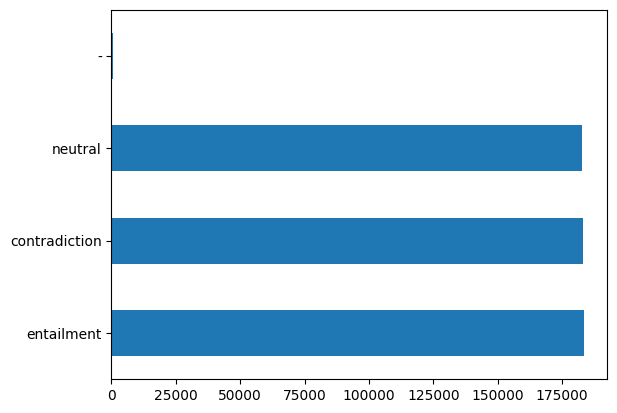

In [2]:
# https://www.kdnuggets.com/fine-tuning-llamav2-with-qlora-on-google-colab-for-free
import pandas as pd


#df = pd.read_csv('snli_1.0_train_matched.csv', sep='\t')
#df = pd.read_csv('./sp-data/firstfinetuning/snli_1.0_train.txt', sep='\t')
df = pd.read_csv('./drive/MyDrive/AAAMachineLearning/Projects/FineTuning/data/snli_1.0_train.txt', sep='\t')
df['gold_label'].value_counts().plot(kind='barh')

In [3]:
df[df['gold_label'] == 'contradiction'].sample(10)[['sentence1', 'sentence2']]

,sentence1,sentence2
58856,A woman wearing a blue scarf and sunglasses is...,The woman is not wearing sunglasses
304357,A man on a three-wheeled motorcycle driving do...,A man is driving by the exhibition hall in a s...
213966,A girl jumping in front of a jukebox mural.,A boy jumping in front of a jukebox mural.
428945,Two women are laughing on the floor with toy w...,The women are not laughing.
326919,Dark-haired man singing into a microphone and ...,A man is juggling knives on stage.
285783,A blond woman taking a photo of her young son ...,A woman is taking a photo of her cat.
324228,A lacrosse player tumbles in mid-game while ot...,A football player practices with his team.
410833,"Child standing on a public bus, looking outsid...",The bus driver is dead.
532803,"A slender man, shirtless with tattoos, carries...",A man is bouncing with excitement about some g...
130057,A farmhand in training points over the barrier...,The farmhand is sitting on his couch.


In [4]:
def convert_to_format(row):
    sentence1 = row['sentence1']
    sentence2 = row['sentence2']
    prompt = """Below is an instruction that describes a task paired with input that provides further context. Write a response that appropriately completes the request."""
    instruction = """Given the following sentence, your job is to generate the negation for it in the json format"""
    input = str(sentence1)
    response = f"""```json
{{'orignal_sentence': '{sentence1}', 'generated_negation': '{sentence2}'}}
```
"""
    if len(input.strip()) == 0:  #  prompt + 2 new lines + ###instruction + new line + input + new line + ###response
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Response:\n" + response
    else:
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Input:\n" + input + "\n" + "\n### Response:\n" + response

    # we need 4 columns for auto train, instruction, input, output, text
    return pd.Series([instruction, input, response, text])

new_df = df[df['gold_label'] == 'contradiction'][['sentence1', 'sentence2']].apply(convert_to_format, axis=1)
new_df.columns = ['instruction', 'input', 'output', 'text']

new_df.to_csv('snli_instruct.csv', index=False)

In [6]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 112.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00


In [7]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [12]:
from google.colab import drive
import pandas as pd

#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/snli_instruct.csv')

#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snli_instruct.csv')
df = pd.read_csv('./snli_instruct.csv')

# New Section